# Convolutional Neural Network

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import time
import matplotlib.pyplot as plt

%matplotlib inline
mx.random.seed(1)

/Users/jsh/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
ctx = mx.cpu()

In [3]:
num_inputs = 784
num_outputs = 10
batch_size = 64
num_fc = 512

# (height, width, channel) -> (channel, height, width)
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1)) / 255, label.astype(np.float32)

train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train = True, transform = transform),
                                      batch_size, shuffle = True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train = False, transform = transform),
                                      batch_size, shuffle = False)

In [4]:
class CNN(gluon.Block):
    def __init__(self, num_fc, num_outputs, **kwargs):
        super(CNN, self).__init__(**kwargs)
        
        with self.name_scope():
            self.conv0 = gluon.nn.Conv2D(channels=4, kernel_size=5, activation='relu')
            self.max0 = gluon.nn.MaxPool2D(pool_size=2, strides=2)
            self.conv1 = gluon.nn.Conv2D(channels=8, kernel_size=5, activation='relu')
            self.max1 = gluon.nn.MaxPool2D(pool_size=2, strides=2)
            self.flat = gluon.nn.Flatten()
            self.dense0 = gluon.nn.Dense(num_fc, activation="relu")
            self.dense1 = gluon.nn.Dense(num_outputs)
            
    def forward(self, x):
        x = self.conv0(x)
        x = self.max0(x)
        x = self.conv1(x)
        x = self.max1(x)
        x = self.flat(x)
        x = self.dense0(x)
        x = self.dense1(x)
        return x    

In [5]:
net = CNN(num_fc=num_fc, num_outputs=num_outputs)
print(net)

CNN(
  (conv0): Conv2D(None -> 4, kernel_size=(5, 5), stride=(1, 1))
  (max0): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv1): Conv2D(None -> 8, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (flat): Flatten
  (dense0): Dense(None -> 512, Activation(relu))
  (dense1): Dense(None -> 10, linear)
)


In [6]:
net.collect_params().initialize(mx.init.Xavier(), ctx = ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [7]:
for data, label in test_data:
    data = data.as_in_context(ctx)
    break

In [8]:
print(net)

CNN(
  (conv0): Conv2D(None -> 4, kernel_size=(5, 5), stride=(1, 1))
  (max0): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv1): Conv2D(None -> 8, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (flat): Flatten
  (dense0): Dense(None -> 512, Activation(relu))
  (dense1): Dense(None -> 10, linear)
)


In [9]:
def evaluate_accuracy(dataset, net):
    acc = mx.metric.Accuracy()
    for data, label in dataset:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        pred = nd.argmax(output, axis=1)
        acc.update(preds = pred, labels = label)
    return acc.get()[1] # ('accuracy', 0.0953)

In [10]:
epochs = 5
smoothing_constant = .01

start_time = time.time()

for i in range(epochs):
    for j, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (j == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)

    train_accuracy = evaluate_accuracy(train_data, net)    
    test_accuracy = evaluate_accuracy(test_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (i, moving_loss, train_accuracy, test_accuracy))
    
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0. Loss: 0.10619983041, Train_acc 0.959733333333, Test_acc 0.9606
Epoch 1. Loss: 0.0641632130318, Train_acc 0.985, Test_acc 0.9824
Epoch 2. Loss: 0.0518702731358, Train_acc 0.9838, Test_acc 0.981
Epoch 3. Loss: 0.0413339389434, Train_acc 0.988066666667, Test_acc 0.9847
Epoch 4. Loss: 0.0319808226525, Train_acc 0.98935, Test_acc 0.9828
--- 162.86263132095337 seconds ---


### HybridBlock

In [11]:
class CNN_hybrid(gluon.HybridBlock):
    def __init__(self, num_fc, num_outputs, **kwargs):
        super(CNN_hybrid, self).__init__(**kwargs)
        
        with self.name_scope():
            self.conv0 = gluon.nn.Conv2D(channels=4, kernel_size=5)
            self.max0 = gluon.nn.MaxPool2D(pool_size=2, strides=2)
            self.conv1 = gluon.nn.Conv2D(channels=16, kernel_size=5)
            self.max1 = gluon.nn.MaxPool2D(pool_size=2, strides=2)
            self.flat = gluon.nn.Flatten()
            self.dense0 = gluon.nn.Dense(num_fc)
            self.dense1 = gluon.nn.Dense(num_outputs)
            
    def hybrid_forward(self, F, x):
        x = self.max0(F.relu(self.conv0(x)))
        x = self.max1(F.relu(self.conv1(x)))        
        x = self.flat(x)
        x = F.relu(self.dense0(x))
        x = self.dense1(x)
        return x    

In [12]:
hnet = CNN_hybrid(num_fc=num_fc, num_outputs=num_outputs)
print(hnet)

CNN_hybrid(
  (conv0): Conv2D(None -> 4, kernel_size=(5, 5), stride=(1, 1))
  (max0): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (conv1): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (flat): Flatten
  (dense0): Dense(None -> 512, linear)
  (dense1): Dense(None -> 10, linear)
)


In [13]:
hnet.collect_params().initialize(mx.init.Xavier(), ctx = ctx)

In [14]:
hnet.hybridize()

In [15]:
trainerH = gluon.Trainer(hnet.collect_params(), 'sgd', {'learning_rate': 0.1})

In [16]:
### To symbolic...

### Visualize activation

In [17]:
img = nd.transpose(data[0:1][0], (1,2,0))

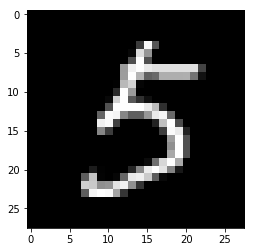

In [18]:
plt.imshow(nd.tile(img, (1,1,3)).asnumpy())
plt.show()

In [19]:
print(label[0], nd.argmax(net(data[0:1]), axis=1))


[ 5.]
<NDArray 1 @cpu(0)> 
[ 5.]
<NDArray 1 @cpu(0)>


In [20]:
# Useful function to arrange the images to be shown as a squared grid
def viz_grid(Xs, ubound=255.0, padding=1):
    import math
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

In [21]:
net.conv0.weight.data().shape

(4, 1, 5, 5)

In [22]:
net.conv1.weight.data().shape

(8, 4, 5, 5)

In [23]:
#conv0_out = nd.split(net.conv0(data[0:1].as_in_context(ctx)), num_outputs=1, axis=0, squeeze_axis=1)
conv0_out = net.conv0(data[0:1].as_in_context(ctx))
print(conv0_out.shape)

(1, 4, 24, 24)


In [24]:
#conv1_out = nd.split(net.conv1(net.max0(net.conv0(data[0:1]))), num_outputs=1, axis=0, squeeze_axis=1)
conv1_out = net.conv1(net.max0(net.conv0(data[0:1])))
print(conv1_out.shape)

(1, 8, 8, 8)


In [25]:
def getActivation_mnist(layer_out):
    outs = nd.transpose(layer_out, (1, 2, 3, 0)) # N, H, W, C
    fig = plt.figure(figsize=(4,4))   
    ax1 = plt.subplot(111)
    grid = viz_grid(outs.asnumpy())
    ax1.imshow(grid[...,0])

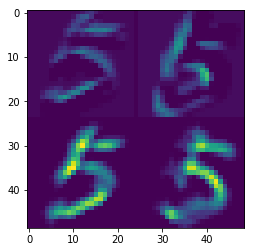

In [26]:
getActivation_mnist(conv0_out)

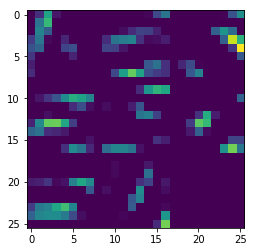

In [27]:
getActivation_mnist(conv1_out)